# 1. Player's statistics from demos

## 1.1 Map independent stats

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)

# ---------- Prepare data ---------- #

killdemo = os.listdir('../scrape-parse/demo/parse/2022/kills/')
kills = pd.DataFrame()


for i in range(0,400):
    temp = pd.read_csv('../scrape-parse/demo/parse/2022/kills/' + killdemo[i])
    kills = pd.concat([kills, temp])

kills['attackerName'] = kills['attackerName'].str.strip()
kills = kills.reset_index(drop=True)
kills['one'] = 1
# kills = kills.loc[kills['attackerName'].isna() == False]
kills.head(5)

,Unnamed: 0,tick,seconds,clockTime,attackerSteamID,attackerName,attackerTeam,attackerSide,attackerX,attackerY,attackerZ,attackerViewX,attackerViewY,victimSteamID,victimName,victimTeam,victimSide,victimX,victimY,victimZ,victimViewX,victimViewY,assisterSteamID,assisterName,assisterTeam,assisterSide,isSuicide,isTeamkill,isWallbang,penetratedObjects,isFirstKill,isHeadshot,victimBlinded,attackerBlinded,flashThrowerSteamID,flashThrowerName,flashThrowerTeam,flashThrowerSide,noScope,thruSmoke,distance,isTrade,playerTradedName,playerTradedTeam,playerTradedSteamID,playerTradedSide,weapon,weaponClass,roundNum,matchID,mapName,one
0,0,14049,12.171875,01:43,7.656120e+16,cadiaN,Heroic,T,-861.150391,-765.311035,32.031250,46.538086,356.951294,76561197989430253,karrigan,FaZe Clan,CT,-577.013367,-450.809509,58.225182,211.184692,5.855713,NaN,NaN,NaN,NaN,False,False,False,0,True,False,True,False,7.656120e+16,jabbi,Heroic,T,False,False,424.654189,False,NaN,NaN,NaN,NaN,Glock-18,Pistols,1,BLAST-Premier-Fall-Final-2022-faze-vs-heroic-b...,de_ancient,1
1,1,14401,14.921875,01:41,7.656120e+16,rain,FaZe Clan,CT,-492.256561,-189.126007,56.030396,241.094971,0.988770,76561197996678278,TeSeS,Heroic,T,-856.432190,-841.970459,36.497665,59.331665,358.461914,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,747.804316,False,NaN,NaN,NaN,NaN,USP-S,Pistols,1,BLAST-Premier-Fall-Final-2022-faze-vs-heroic-b...,de_ancient,1
2,2,16500,31.320312,01:24,7.656120e+16,rain,FaZe Clan,CT,221.817154,-757.159729,153.031250,124.233398,351.765747,76561198160709585,sjuush,Heroic,T,53.596638,-503.480255,180.897919,299.333496,4.586792,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,305.659891,False,NaN,NaN,NaN,NaN,USP-S,Pistols,1,BLAST-Premier-Fall-Final-2022-faze-vs-heroic-b...,de_ancient,1
3,3,19064,51.351562,01:04,7.656120e+16,Twistzz,FaZe Clan,CT,-1340.946045,180.911392,87.031250,107.644043,2.878418,76561198004115516,cadiaN,Heroic,T,-1618.489746,1040.405273,52.031250,241.885986,3.773804,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,903.872357,False,NaN,NaN,NaN,NaN,USP-S,Pistols,1,BLAST-Premier-Fall-Final-2022-faze-vs-heroic-b...,de_ancient,1
4,4,19808,57.164062,00:58,7.656120e+16,jabbi,Heroic,T,1062.584717,-847.473938,3.505107,176.088867,352.040405,76561197997351207,rain,FaZe Clan,CT,-144.543045,-771.454163,153.031250,357.681885,7.443237,NaN,NaN,NaN,NaN,False,False,False,0,False,True,False,False,NaN,NaN,NaN,NaN,False,False,1218.726592,False,NaN,NaN,NaN,NaN,Glock-18,Pistols,1,BLAST-Premier-Fall-Final-2022-faze-vs-heroic-b...,de_ancient,1


In [63]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


# ---------- Player stats ---------- #

players = pd.DataFrame(kills[['attackerName']])
players['attackerName'] = players['attackerName'].str.strip()
players = players.drop_duplicates(subset=['attackerName']).reset_index(drop=True).sort_values(by=['attackerName'])

# Matches played
kills['matches_played'] = kills.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['one'].transform('sum')
kill_test = kills.loc[kills['matches_played'].notna() == True].drop_duplicates(subset=['attackerName'])
players = players.merge(kill_test[['attackerName','matches_played']], on='attackerName', how='left')

# Kill count
kills['kill_count'] = kills.groupby(by=['attackerName'])['one'].transform('sum')
players = players.merge(kills[['attackerName','kill_count']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPM - kills per match
players['KPM'] = players['kill_count'] / players['matches_played']

# KPR - kills per round
rounds = kills[['matchID','roundNum']].sort_values(by=['matchID','roundNum']).drop_duplicates(subset=['matchID'],keep='last').rename(columns={'roundNum':'rounds_played'})
kills = kills.merge(rounds, on='matchID', how='left')
kills['KPM'] = kills[['attackerName','matchID','one']].groupby(by=['attackerName','matchID'])['one'].transform('sum')
kills['KPR_match'] = kills['KPM'] / kills['rounds_played']
kills['KPR'] = kills[['attackerName','KPR_match']].groupby(by=['attackerName'])['KPR_match'].transform('mean')
players = players.merge(kills[['attackerName','KPR']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted KPM
players['weighted_KPM'] = players['KPM'] * (players['matches_played'] / players['matches_played'].max())

# Headshot %
kills['hs_count'] = kills.groupby(by=['attackerName'])['isHeadshot'].transform('sum')
kills['HS%'] = kills['hs_count'] / kills['kill_count']
players = players.merge(kills[['attackerName','HS%']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# Weighted HS%
players['weighted_HS%'] = players['HS%'] * (players['matches_played'] / (players['matches_played'].max() - players['matches_played'].min()))

pd.set_option('display.max_rows', 100)
players.sort_values(by=['weighted_HS%'], ascending=False).head(5)

,attackerName,matches_played,kill_count,KPM,KPR,weighted_KPM,HS%,weighted_HS%
72,Twistzz,67.0,1223.0,18.253731,0.736646,18.253731,0.567457,0.584917
159,rain,67.0,1179.0,17.597015,0.711963,17.597015,0.519084,0.535056
87,b1t,56.0,1063.0,18.982143,0.763342,15.865672,0.610536,0.526000
161,ropz,67.0,1299.0,19.388060,0.777367,19.388060,0.504234,0.519749
131,karrigan,67.0,957.0,14.283582,0.588701,14.283582,0.496343,0.511615


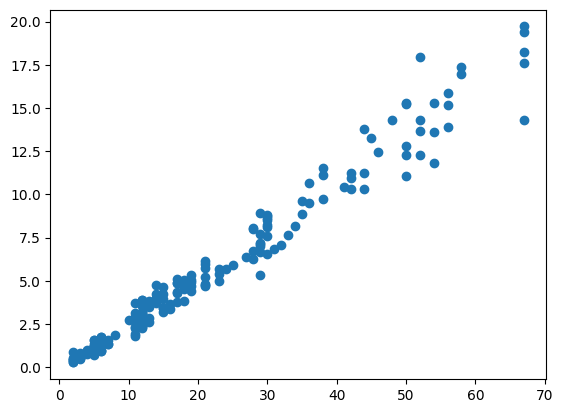

In [64]:
plt.scatter(players['matches_played'],players['weighted_KPM'])

<Axes: >

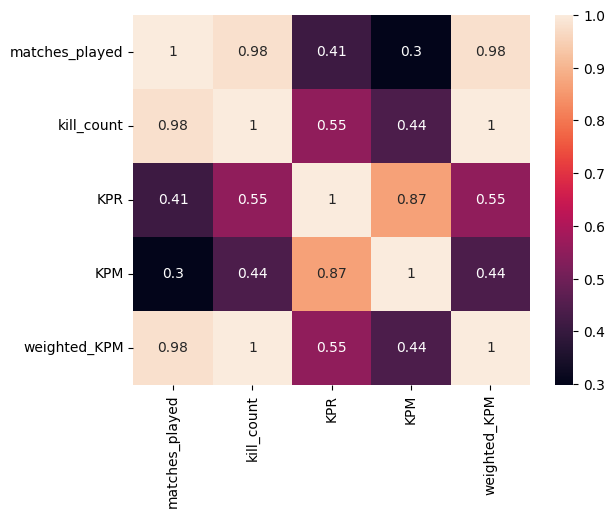

In [6]:
import seaborn as sns

sns.heatmap(players[['matches_played','kill_count','KPR','KPM','weighted_KPM']].corr(), annot=True)

Text(0, 0.5, 'weighted_KPM')

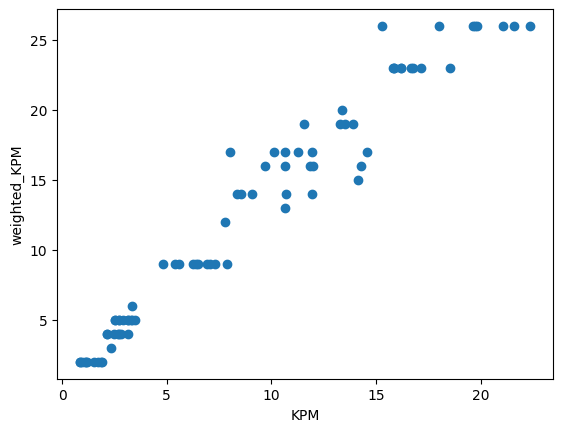

In [11]:
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

players_plot = players.loc[players['attackerName'].notna() == True]

plt.scatter(players_plot['weighted_KPM'],players_plot['matches_played'])
plt.xlabel('KPM')
plt.ylabel('weighted_KPM')